# The Economic Value of Selecting a Major
### Group members: Patrick Pu, Eddie Sebor, Robert Xu, Xiaoyu Zhang

We were originally inspired by this 538 article: https://fivethirtyeight.com/features/the-economic-guide-to-picking-a-college-major/
here, the author uses data from 2010 to analyze the highest paying majors, concluding that most of them were engineering related. Recently, with the burst of AI, machine learning, and data science across all industries, we want to investigate what the current highest paying majors are.

We found data from the US department of education (https://collegescorecard.ed.gov/data/).

The primary purpose of the Scorecard is to provide data to help prospective postsecondary students make informed enrollment decisions. 

We will be exploring two data sets, one dataset is aggregated per institute, and the other aggregated per field of study. 
We will join these datasets and potentially design an earnings model that gives us insights on how to pick a college and major.

Data dictionary explaining the variable abbreviations can be found here: https://collegescorecard.ed.gov/data/documentation/

Technical documentation can be found here: 
1. https://collegescorecard.ed.gov/assets/FullDataDocumentation.pdf
1. https://collegescorecard.ed.gov/assets/FieldOfStudyDataDocumentation.pdf

The institutional dataset consists aggregate statistics for 7112 colleges in the US. There are 1, 978 variables for each institution.
The fields data set has 216638 entries and 18 columns.

## Workflow
1. Introduce problem, 538 article, data source, 2 datasets, data columns, visualizations
1. explain variable selection, data cleaning methods. Reference technical documents on why we drop na values.
1. Answer some questions with our clean data - which majors pay most, which region pays most, does higher family income result in higher personal income
1. Introduce model, use model to explain factors that most influence a person's income. 
1. Improvements -- drawback due to nature of educational data, lots of data supressed due to privacy reasons.

## Questions to answer:
1. have there been any shifts in the highest paying majors over the past decade?
1. Does coming from a higher income household result in a higher paying job as well?
1. Is it worth getter a higher level degree? (see implementation 2)
1. What is the economic value of diversity? Does attending a more diverse school increase your chances of earning more?
1. Which schools leave you with higher debt after graduation?
1. Do schools that give out more federal loans help students earn more after graduation?
1. Compare ivy school earnings to others
1. Compare income from minority/religious/remote schools
1. Do more expensive schools lead to more lucrative careers? (Compare earnings with tuition/cost)
1. Do schools that pay faculty more produce higher quality students? (AVGFACSAL)
1. Do more competitive schools (lower admission rate) produce higher salaried workers?
1. Do institutions that are more accessible to low-income students provide the same career opportunities as other schools? (look at FTFTPCTPELL, first_time_aid)

## Some implementation ideas
1. Add features: 
        monthly_income / monthly_debt
        monthly_income - monthly_debt
        log(income), log(debt)
        years_to_pay_off debt
1. Compare income/debt of bach vs masters vs phds for the same cip_code

1. Maybe select a certain subset of majors to build up your income model

## Data

College Scorecard provides 1) data files with data about institutions as a whole and 2) data files with
data about specific fields of study within institutions. These data are provided through federal reporting from institutions, data on federal financial aid, and tax information. These data provide insights into the performance of
institutions that receive federal financial aid dollars, and the outcomes of the students of those
institutions Many elements are available only for Title IV recipients, or students who receive federal grants and
loans

College Scorecard composes its data from various sources: FSA (Federal Student Aid), IPEDS (Integrated Postsecondary Education Data System), NSLDS (National Student Loan Data System), OPE, US Treasury

# Exploratory Data Analysis

In [ ]:
!conda list matplotlib

In [2]:
# Run this cell if multiple versions of matplotlib were installed
#!pip uninstall matplotlib-2.2.2
#!pip install missingno
#!pip install missingno
#!pip install seaborn

In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import missingno as msno

from scipy.stats import pearsonr

from sklearn.feature_selection import SelectKBest, chi2, f_regression

from pyspark.sql.types import StructField, StructType, StringType, LongType
from pyspark.sql.functions import isnan, when, count, col, sum, avg, expr, log, min, max
from pyspark.sql import functions as F

from pyspark.ml.feature import RFormula
from pyspark.ml.feature import VectorIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

## Reading the fields data

In [2]:
data = "gs://is843-team-1/data/"
Fields = spark.read.format("csv")\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data + "Most-Recent-Field-Data-Elements.csv")
#Fields.printSchema()

In [3]:
print("The original fields dataset has {} columns and {} rows".format(len(Fields.columns), Fields.count()))

The original fields dataset has 18 columns and 216638 rows


Spark didn't do the best job at infering the data types, instead we reference the CollegeScorecard API to recast the values oursleves

In [4]:
# Clean DataFrame
target_columns = [ "UNITID", "INSTNM", "OPEID6", "CIPCODE", "CIPDESC", "CREDLEV", "COUNT", "DEBTMEAN", "DEBTMEDIAN", "DEBTPAYMENT10YR", "EARNINGSCOUNT", "MD_EARN_WNE"]

cdf = Fields.select(target_columns)\
    .withColumnRenamed("UNITID", "id")\
    .withColumnRenamed("INSTNM", "institution_name")\
    .withColumnRenamed("CREDLEV", "credential_level")\
    .withColumnRenamed("CIPDESC", "field_description")\
    .withColumnRenamed("OPEID6", "opeid6")\
    .withColumn("count", col("COUNT").cast("int"))\
    .withColumn("mean_debt", col("DEBTMEAN").cast("int"))\
    .withColumn("median_debt", col("DEBTMEDIAN").cast("int"))\
    .withColumn("monthly_debt_payment", col("DEBTPAYMENT10YR").cast("int"))\
    .withColumn("earnings_count", col("EARNINGSCOUNT").cast("int"))\
    .withColumn("median_earnings", col("MD_EARN_WNE").cast("int"))\
    .withColumn("cip_code", col("CIPCODE").cast("string"))\
    .withColumn("field_debt", col("count") * col("median_debt"))\
    .withColumn("field_earnings", col("count") * col("median_earnings"))
    
cdf = cdf.drop("INSTNM", "DEBTMEAN", "DEBTMEDIAN", "DEBTPAYMENT10YR", "EARNINGSCOUNT", "MD_EARN_WNE", "CIPCODE")

Sample of our data where there aren'y any missing values

In [5]:
cdf.where(~col("median_debt").isNull()).where(~col("earnings_count").isNull()).sample(True, fraction = 0.001, seed = 843).show(10, False)

+------+----------------------------------------------------------------+------+----------------------------------------------------------------------------+----------------+-----+---------+-----------+--------------------+--------------+---------------+--------+----------+--------------+
|id    |institution_name                                                |opeid6|field_description                                                           |credential_level|count|mean_debt|median_debt|monthly_debt_payment|earnings_count|median_earnings|cip_code|field_debt|field_earnings|
+------+----------------------------------------------------------------+------+----------------------------------------------------------------------------+----------------+-----+---------+-----------+--------------------+--------------+---------------+--------+----------+--------------+
|110413|California Lutheran University                                  |1133  |Communication and Media Studies.                  

Check for percentage of missing values in each column

Let's see what the top paying undergraduate degrees at Boston University are:

In [6]:
cdf.select("field_description","count", "median_debt","median_earnings").where(cdf.institution_name.isin("Boston University")).where(col("credential_level") == 3).orderBy(col("median_earnings").desc()).show(10, False)

+-------------------------------------------------------+-----+-----------+---------------+
|field_description                                      |count|median_debt|median_earnings|
+-------------------------------------------------------+-----+-----------+---------------+
|Computer Engineering.                                  |78   |26892      |80000          |
|Computer Science.                                      |112  |25000      |78200          |
|Electrical, Electronics and Communications Engineering.|43   |24944      |67800          |
|Mechanical Engineering.                                |157  |26870      |66900          |
|Business Administration, Management and Operations.    |547  |25000      |56300          |
|Biomedical/Medical Engineering.                        |132  |25832      |55300          |
|Multi/Interdisciplinary Studies, Other.                |34   |24750      |52600          |
|Economics.                                             |121  |25000      |50000

The top paying Bachelor's degrees in the country: a lot of cs stuff

In [7]:
# Bachelor's Degree
bach_df = cdf.select("institution_name", "field_description", "count", "median_debt","median_earnings").where(col("credential_level") == 3).orderBy(col("median_earnings").desc())
bach_df.show(10, False)

+-------------------------------------+-------------------------------------------+-----+-----------+---------------+
|institution_name                     |field_description                          |count|median_debt|median_earnings|
+-------------------------------------+-------------------------------------------+-----+-----------+---------------+
|California Institute of Technology   |Computer and Information Sciences, General.|null |null       |153300         |
|Brown University                     |Computer Science.                          |68   |12871      |141100         |
|Carnegie Mellon University           |Computer Science.                          |86   |20510      |138900         |
|University of Pennsylvania           |Computer and Information Sciences, General.|36   |19500      |135200         |
|Harvard University                   |Computer Science.                          |null |null       |128900         |
|Stanford University                  |Computer Science.

Which degrees put you in the most debt? Seems to be dentistry.

In [8]:
cdf.select("institution_name", "field_description", "credential_level", "median_debt","median_earnings").orderBy(col("median_debt").desc()).show(10, False)

+--------------------------------------------+-----------------+----------------+-----------+---------------+
|institution_name                            |field_description|credential_level|median_debt|median_earnings|
+--------------------------------------------+-----------------+----------------+-----------+---------------+
|Roseman University of Health Sciences       |Dentistry.       |6               |410213     |98400          |
|University of Southern California           |Dentistry.       |7               |403691     |85400          |
|Midwestern University-Downers Grove         |Dentistry.       |6               |396756     |115700         |
|University of New England                   |Dentistry.       |6               |393575     |null           |
|Western University of Health Sciences       |Dentistry.       |7               |393548     |106900         |
|New York University                         |Dentistry.       |7               |387660     |69600          |
|Nova Sout

# Reading the institutional level data

In [9]:
data = "gs://is843-team-1/data/"
Colleges = spark.read.format("csv")\
  .option("inferSchema", "True")\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data + "Most-Recent-Cohorts-All-Data-Elements.csv")

In [10]:
target_columns = ['UNITID', 'INSTNM', 'STABBR','ZIP','AGE_ENTRY', 'CCSIZSET', 'D100_4_POOLED','FAMINC','FEMALE','FIRST_GEN',
                  'ICLEVEL','INC_PCT_LO','LN_MEDIAN_HH_INC','LNFAMINC','LOAN_COMP_ORIG_YR4_RT','LOAN_EVER','LOCALE','MD_FAMINC',
                  'MEDIAN_HH_INC','NOTFIRSTGEN_DEBT_MDN','NUMBRANCH','PAR_ED_PCT_1STGEN','PCIP01','PCIP09','PCIP11','PCIP14','PCIP22','PCIP23','PCIP26','PCIP27','PCIP42','PCIP51',
                  'PCIP52','PCTFLOAN','PCTPELL','PELL_DEBT_MDN','SAT_AVG','SAT_AVG_ALL','SD_EARN_WNE_P6','TUITFTE','TUITIONFEE_IN','TUITIONFEE_OUT','UG','UG_AIANOLD','UG_API',
                  'UG_BLACKNH','UG_HISPOLD','UG_NRA','UG_WHITENH','UGDS', 'UNEMP_RATE', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'NANTI', 'RELAFFIL', 'DISTANCEONLY', 'AVGFACSAL',
                  'CIPCODE1', 'CIPCODE2', 'ADM_RATE_ALL', 'COSTT4_A', 'CIPTITLE1', 'CIPTITLE2'
 ]
inst_df = Colleges.select(target_columns)

# Column names that end with _p is a column of percentages
inst_df = inst_df\
    .withColumn("zip", col("ZIP").cast("int"))\
    .withColumn("age", col("AGE_ENTRY").cast("int"))\
    .withColumn("state", col("STABBR").cast("string"))\
    .withColumn("carnegie_size_setting", col("CCSIZSET").cast("int"))\
    .withColumn("completion_count", col("D100_4_POOLED").cast("int"))\
    .withColumn("family_income", col("FAMINC").cast("int"))\
    .withColumn("female", col("FEMALE").cast("float"))\
    .withColumn("first_gen", col("FIRST_GEN").cast("float"))\
    .withColumn("aid_p", col("INC_PCT_LO").cast("float"))\
    .withColumn("log_median_income", col("LN_MEDIAN_HH_INC").cast("long"))\
    .withColumn("avg_log_income", col("LNFAMINC").cast("float"))\
    .withColumn("og_loan_p", col("LOAN_COMP_ORIG_YR4_RT").cast("float"))\
    .withColumn("fed_loan_p", col("LOAN_EVER").cast("float"))\
    .withColumn("median_fam_income", col("MD_FAMINC").cast("long"))\
    .withColumn("median_household_income", col("MEDIAN_HH_INC").cast("int"))\
    .withColumn("median_non_fg_debt", col("NOTFIRSTGEN_DEBT_MDN").cast("int"))\
    .withColumn("num_branches", col("NUMBRANCH").cast("float"))\
    .withColumn("first_gen_p", col("PAR_ED_PCT_1STGEN").cast("float"))\
    .withColumn("agriculture_p", col("PCIP01").cast("float"))\
    .withColumn("journalism_p", col("PCIP09").cast("float"))\
    .withColumn("computer_science_p", col("PCIP11").cast("float"))\
    .withColumn("engineering_p", col("PCIP14").cast("float"))\
    .withColumn("legal_p", col("PCIP22").cast("float"))\
    .withColumn("english_p", col("PCIP23").cast("float"))\
    .withColumn("biological_p", col("PCIP26").cast("float"))\
    .withColumn("math_p", col("PCIP27").cast("float"))\
    .withColumn("psychology_p", col("PCIP42").cast("float"))\
    .withColumn("health_p", col("PCIP51").cast("float"))\
    .withColumn("business_p", col("PCIP52").cast("float"))\
    .withColumn("ugrad_loan_p", col("PCTFLOAN").cast("float"))\
    .withColumn("pell_p", col("PCTPELL").cast("float"))\
    .withColumn("med_debt_pell", col("PELL_DEBT_MDN").cast("float"))\
    .withColumn("Average SAT", col("SAT_AVG").cast("float"))\
    .withColumn("Average SAT all", col("SAT_AVG_ALL").cast("float"))\
    .withColumn("Standard deviation of earnings", col("SD_EARN_WNE_P6").cast("int"))\
    .withColumn("Net tuition revenue", col("TUITFTE").cast("int"))\
    .withColumn("tuition_in", col("TUITIONFEE_IN").cast("int"))\
    .withColumn("tuition_out", col("TUITIONFEE_OUT").cast("int"))\
    .withColumn("Enrollment", col("UG").cast("float"))\
    .withColumn("%American Indian/Alaska Native", col("UG_AIANOLD").cast("float"))\
    .withColumn("%Asian/Pacific Islander", col("UG_API").cast("float"))\
    .withColumn("%black non-Hispanic", col("UG_BLACKNH").cast("float"))\
    .withColumn("%Hispanic", col("UG_HISPOLD").cast("float"))\
    .withColumn("%non-resident aliens", col("UG_NRA").cast("float"))\
    .withColumn("%white non-Hispanic", col("UG_WHITENH").cast("float"))\
    .withColumn("ugrads_enrolled", col("UGDS").cast("int"))\
    .withColumn("faculty_salary", col("AVGFACSAL").cast("int"))\
    .withColumn("unemployment_rate", col("UNEMP_RATE").cast("float"))\
    .withColumn("admission_rate", col("ADM_RATE_ALL").cast("float"))\
    .withColumn("cost_of_attendance", col("COSTT4_A").cast("int"))\
    .withColumnRenamed("PBI", "mostly_black")\
    .withColumnRenamed("RELAFFIL", "religious_affiliation")\
    .withColumnRenamed("DISTANCEONLY","remote_only")\
    .withColumnRenamed("CIPCODE1", "largest_cip")\
    .withColumnRenamed("CIPCODE2", "second_largest_cip")\
    .withColumnRenamed("CIPTITLE1", "largest_program")\
    .withColumnRenamed("CIPTITLE2", "second_largest_program")\
    .withColumnRenamed("UNITID", "id")
    
    #.withColumn("", col("").cast(""))\

columns_drop = ['INSTNM', 'STABBR','ZIP','AGE_ENTRY','MD_EARN_WNE_P6','MD_EARN_WNE_P10','CUML_DEBT_P75','D100_4_POOLED','FAMINC','FEMALE','FIRST_GEN','GRAD_DEBT_MDN','HI_INC_COMP_4YR_TRANS_YR4_RT',
                  'ICLEVEL','INC_PCT_LO','LN_MEDIAN_HH_INC','LNFAMINC','LOAN_COMP_ORIG_YR4_RT','LOAN_EVER','LOCALE','MD_FAMINC',
                  'MEDIAN_HH_INC','NOTFIRSTGEN_DEBT_MDN','NUMBRANCH','PAR_ED_PCT_1STGEN','PCIP01','PCIP09','PCIP11','PCIP14','PCIP22','PCIP23','PCIP26','PCIP27','PCIP42','PCIP51',
                  'PCIP52','PCTFLOAN','PCTPELL','PELL_DEBT_MDN','SAT_AVG','SAT_AVG_ALL','SD_EARN_WNE_P6','TUITFTE','TUITIONFEE_IN','TUITIONFEE_OUT','UG','UG_AIANOLD','UG_API',
                  'UG_BLACKNH','UG_HISPOLD','UG_NRA','UG_WHITENH','UGDS', 'UNEMP_RATE', 'CCSIZSET', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'NANTI', 'AVGFACSAL', 'ADM_RATE_ALL', 'COSTT4_A']
inst_df = inst_df.drop(*columns_drop)

columns_to_drop = ['completion_count','og_loan_p',
'Average SAT','Average SAT all','%American Indian/Alaska Native','%Asian/Pacific Islander',
'%black non-Hispanic','%Hispanic','%non-resident aliens','%white non-Hispanic','avg_log_income','Enrollment','%Received federal loan']
inst_df = inst_df.drop(*columns_to_drop)
#inst_df.printSchema()

In [38]:
inst_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- mostly_black: string (nullable = true)
 |-- religious_affiliation: string (nullable = true)
 |-- remote_only: string (nullable = true)
 |-- largest_cip: string (nullable = true)
 |-- second_largest_cip: string (nullable = true)
 |-- largest_program: string (nullable = true)
 |-- second_largest_program: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- carnegie_size_setting: integer (nullable = true)
 |-- family_income: integer (nullable = true)
 |-- aid_p: float (nullable = true)
 |-- log_median_income: long (nullable = true)
 |-- fed_loan_p: float (nullable = true)
 |-- median_fam_income: long (nullable = true)
 |-- median_household_income: integer (nullable = true)
 |-- median_non_fg_debt: integer (nullable = true)
 |-- num_branches: float (nullable = true)
 |-- first_gen_p: float (nullable = true)
 |-- agriculture_p: float (nullable = true)
 |-- journalism_p: float (nullable = true)
 |-

The five states that have the lowest average admission rate.

In [47]:
inst_df.dropna().groupBy("state").agg(avg("admission_rate").alias("avg_admission_rate")).orderBy(col("avg_admission_rate")).show(5)

+-----+------------------+
|state|avg_admission_rate|
+-----+------------------+
|   DC|0.5161936368261065|
|   DE|0.5533685013651848|
|   CA|0.5744940432186207|
|   NM|0.5843110457062721|
|   CT|0.5921127792786468|
+-----+------------------+
only showing top 5 rows



## Joining the fields and insitutional level datasets

We drop null median earnings values since this is our target of interest. We will later use a visualization package (missingno) to help us decide how to deal with privacy supressed data points.

We drop missing earnings values because forward/average/zero filling will ultimately skew the distribution of our earnings data.

Data presented by field of study have been treated with cell suppression methods to reduce the risk of
disclosure. To further reduce disclosure risk, information about the specific suppression rules is not
available to the public. Data points suppressed for privacy are indicated by the “PrivacySuppressed” data
code. 

In [11]:
from IPython.display import Image
#Image('gs://is843-team-1/notebooks/jupyter/pic1.png')
#Maybe just do this step locally instead.

In [12]:
print("Check that the column id is a unique identifier for an institution: ")
inst_df.select("id").distinct().count() == inst_df.select("id").count()

Check that the column id is a unique identifier for an institution: 


True

In [13]:
msf = cdf.dropna(subset="median_earnings").join(inst_df, "id")
msf.show(1, False)

+------+------------------------+------+-------------------------------------------+----------------+-----+---------+-----------+--------------------+--------------+---------------+--------+----------+--------------+------------+---------------------+-----------+-----------+------------------+---------------+----------------------+---+-----+---------------------+-------------+----------+-----------------+----------+-----------------+-----------------------+------------------+------------+-----------+-------------+------------+------------------+-------------+-------+---------+------------+------+------------+--------+----------+------------+------+-------------+------------------------------+-------------------+----------+-----------+---------------+--------------+-----------------+--------------+------------------+
|id    |institution_name        |opeid6|field_description                          |credential_level|count|mean_debt|median_debt|monthly_debt_payment|earnings_count|median_

We repartitioned the data into 6 partitions since we are using a 3 node cluster, where each node is a n1-highmem-2 (2 vCPUs, 13 GB memory) machine (6 vCPUs total).
This partitioning allows our data to be more evenly spread out among the workers and allows faster parallel processing.

In [14]:
msf = msf.repartition(6)
print("data was re-partitioned to {} partitions!".format(msf.rdd.getNumPartitions()))

# Setting the number of shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "6")

# Caching the DataFrame
msf.cache()

data was re-partitioned to 6 partitions!


DataFrame[id: string, institution_name: string, opeid6: int, field_description: string, credential_level: int, count: int, mean_debt: int, median_debt: int, monthly_debt_payment: int, earnings_count: int, median_earnings: int, cip_code: string, field_debt: int, field_earnings: int, mostly_black: string, religious_affiliation: string, remote_only: string, largest_cip: string, second_largest_cip: string, largest_program: string, second_largest_program: string, age: int, state: string, carnegie_size_setting: int, family_income: int, aid_p: float, log_median_income: bigint, fed_loan_p: float, median_fam_income: bigint, median_household_income: int, median_non_fg_debt: int, num_branches: float, first_gen_p: float, agriculture_p: float, journalism_p: float, computer_science_p: float, engineering_p: float, legal_p: float, english_p: float, biological_p: float, math_p: float, psychology_p: float, health_p: float, business_p: float, ugrad_loan_p: float, pell_p: float, med_debt_pell: float, Stan

Now that we have cached our joined dataset without any missing median earnings values, we can make some more extensive queries, further explore how to drop other missing values, and construct some features for our final regression model.

# Filtering Missing Values

To investigate how to properly deal with our missing values, we get insight using visualization libraries missingno and seaborn. Below is a plot of a missing no matrix, the shaded grey area shows intact data points; while the white area shows null valued data points. We can see that after droping missing median earnings data when joining our datasets earlier, our masterframe is mostly intact. Also, for each column we calculate the percentage of null values. Finally, we use a Seaborn correlation heatmap and pairwise correlations with our target of interest: median earnings.

Combining these insights, we removed columns that were missing too many values and had low correlation with median earnings.

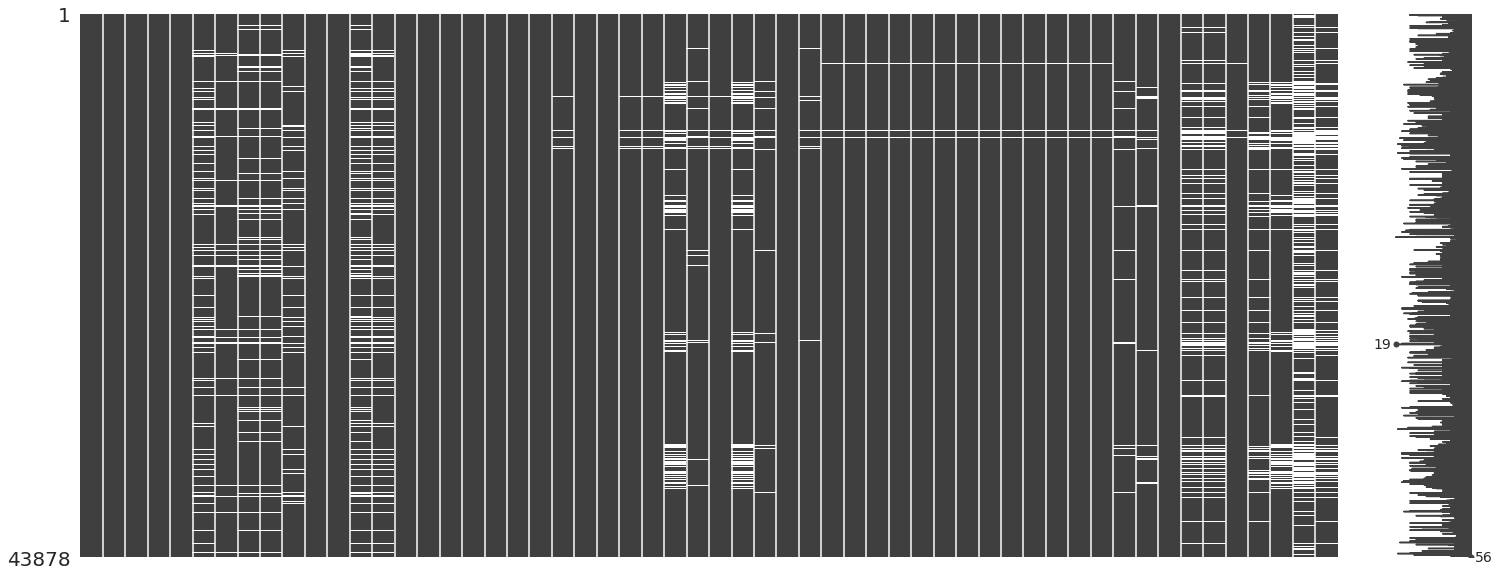

In [15]:
msno.matrix(msf.toPandas())

In [16]:
c_names = msf.columns
count = msf.count()
[(c, msf.where(col(c).isNull()).count()/count) for c in c_names]

[('id', 0.0),
 ('institution_name', 0.0),
 ('opeid6', 0.0),
 ('field_description', 0.0),
 ('credential_level', 0.0),
 ('count', 0.11882948174483796),
 ('mean_debt', 0.03965540817721865),
 ('median_debt', 0.0920051050640412),
 ('monthly_debt_payment', 0.0920051050640412),
 ('earnings_count', 0.06376771958612516),
 ('median_earnings', 0.0),
 ('cip_code', 0.0),
 ('field_debt', 0.16454715347098775),
 ('field_earnings', 0.11882948174483796),
 ('mostly_black', 0.0),
 ('religious_affiliation', 0.0),
 ('remote_only', 0.0),
 ('largest_cip', 0.0),
 ('second_largest_cip', 0.0),
 ('largest_program', 0.0),
 ('second_largest_program', 0.0),
 ('age', 0.009138976252336022),
 ('state', 0.0),
 ('carnegie_size_setting', 0.0),
 ('family_income', 0.009138976252336022),
 ('aid_p', 0.011326860841423949),
 ('log_median_income', 0.12099457586945622),
 ('fed_loan_p', 0.04375769178175851),
 ('median_fam_income', 0.009138976252336022),
 ('median_household_income', 0.12099457586945622),
 ('median_non_fg_debt', 0.0

Text(0.5, 1.0, 'Correlation matrix')

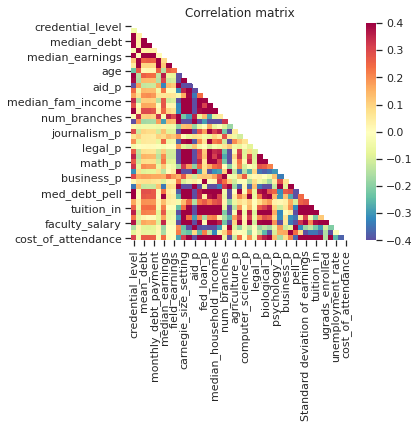

In [17]:
corrs = msf.drop("opeid6").toPandas().corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.4, vmax=.4)
plt.rcParams["figure.figsize"] = (14, 8)
plt.title('Correlation matrix')

Here we have the pairwise correlations between target variable median earnings and all features sorted by adjusted R-squared values. We use adjusted R-squared to account for the phenomenon of the R2 automatically and spuriously increasing when extra explanatory variables are added to the model.

In [18]:
msf.drop("opeid6").toPandas().rcorr(stars=False)

,credential_level,count,mean_debt,median_debt,monthly_debt_payment,earnings_count,median_earnings,field_debt,field_earnings,age,...,med_debt_pell,Standard deviation of earnings,Net tuition revenue,tuition_in,tuition_out,ugrads_enrolled,faculty_salary,unemployment_rate,admission_rate,cost_of_attendance
credential_level,-,0.000,0.,0.,0.,0.000,0.,0.000,0.000,0.,...,0.,0.,0.000,0.,0.,0.,0.,0.000,0.000,0.
count,-0.041,-,0.000,0.000,0.000,0.,0.156,0.,0.,0.,...,0.001,0.030,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
mean_debt,0.659,0.036,-,0.,0.,0.000,0.,0.,0.000,0.005,...,0.,0.,0.,0.,0.,0.000,0.000,0.000,0.000,0.
median_debt,0.636,0.038,0.99,-,0.,0.000,0.,0.,0.000,0.000,...,0.,0.,0.,0.,0.,0.133,0.000,0.000,0.000,0.
monthly_debt_payment,0.65,0.033,0.991,0.999,-,0.000,0.,0.,0.000,0.000,...,0.,0.,0.000,0.,0.,0.023,0.000,0.000,0.000,0.
earnings_count,-0.022,0.979,0.04,0.043,0.039,-,0.029,0.,0.,0.,...,0.003,0.390,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
median_earnings,0.566,-0.007,0.454,0.437,0.446,0.011,-,0.000,0.000,0.000,...,0.,0.,0.000,0.,0.,0.000,0.,0.000,0.000,0.
field_debt,0.12,0.911,0.252,0.261,0.255,0.902,0.089,-,0.,0.,...,0.000,0.000,0.000,0.809,0.000,0.000,0.000,0.739,0.580,0.041
field_earnings,0.049,0.943,0.092,0.092,0.089,0.937,0.12,0.9,-,0.,...,0.000,0.000,0.000,0.068,0.000,0.000,0.000,0.477,0.677,0.652
age,-0.228,0.264,0.014,0.02,0.018,0.248,-0.144,0.254,0.233,-,...,0.,0.,0.000,0.,0.,0.,0.,0.,0.000,0.


In [19]:
#['credential_level', 'pell_p', 'admission_rate', 'cost_of_attendance', 'faculty_salary', 'tuition_in', 'tuition_out', 'family_income', 'ugrad_loans','computer_science_p']
temp = msf.drop("opeid6").toPandas()
cols = [[c for c in msf.columns if c != 'median_earnings' ], ['median_earnings']]
pairwise_corr = pg.pairwise_corr(temp, method='pearson', columns = cols)
pairwise_corr.sort_values(by=['adj_r2'], ascending=False)[['X', 'Y', 'n', 'r', 'adj_r2', 'p-unc']].round(2)

,X,Y,n,r,adj_r2,p-unc
0,credential_level,median_earnings,43878,0.57,0.32,0.00
2,mean_debt,median_earnings,42138,0.45,0.21,0.00
4,monthly_debt_payment,median_earnings,39841,0.45,0.20,0.00
3,median_debt,median_earnings,39841,0.44,0.19,0.00
33,Standard deviation of earnings,median_earnings,42197,0.41,0.17,0.00
9,carnegie_size_setting,median_earnings,43878,0.36,0.13,0.00
38,faculty_salary,median_earnings,39604,0.35,0.12,0.00
31,pell_p,median_earnings,43505,-0.34,0.12,0.00
11,aid_p,median_earnings,43381,-0.32,0.10,0.00
10,family_income,median_earnings,43477,0.31,0.09,0.00


Further investigating: some values are represented as the literal string "NULL", need to remove these columns!

In [20]:
msf.select("religious_affiliation", "largest_cip", 'largest_program', ).sample(True, 0.01, 843).show(10)
temp = msf.filter(col("religious_affiliation") == "NULL").count() / msf.count() 
print("The column religious affiliation has {:.2f}% null values, so we will drop this column for our final analysis".format(temp * 100))

+---------------------+-----------+---------------+
|religious_affiliation|largest_cip|largest_program|
+---------------------+-----------+---------------+
|                   30|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
|                 NULL|       NULL|           NULL|
+---------------------+-----------+---------------+
only showing top 10 rows

The column religious affiliation has 88.25% null values, so we will drop this column for our final analysis


In [21]:
drop_cols = ['admission_rate', 'num_branches', 'religious_affiliation', 'earnings_count', 
            'legal_p', 'agriculture_p', 'num_branches', 'agriculture_p', 'fed_loan_p', 'log_median_income', 
            'tuition_in', 'tuition_out', "largest_cip", 'largest_program', 'second_largest_cip',
            'second_largest_program', 'cost_of_attendance', 'unemployment_rate', 'median_household_income']
MSF = msf.drop(*drop_cols)
MSF_count = MSF.count()
cdf_count = cdf.count()
MSF = MSF.dropna()
print("After final cleaning, we end up with {} rows and {} columns. We retain {}% of the original data, we retain {}% of the existing earning values.".format(MSF_count,len(MSF.columns),MSF_count * 100/cdf_count, MSF.count() * 100/msf.count()))

After final cleaning, we end up with 43878 rows and 39 columns. We retain 20.254064383903103% of the original data, we retain 73.92998769314919% of the existing earning values.


Recall we have just a low data retention rate since we dropped our privacy suppressed median earnings data earlier.
Check that our final DataFrame has no missing value:

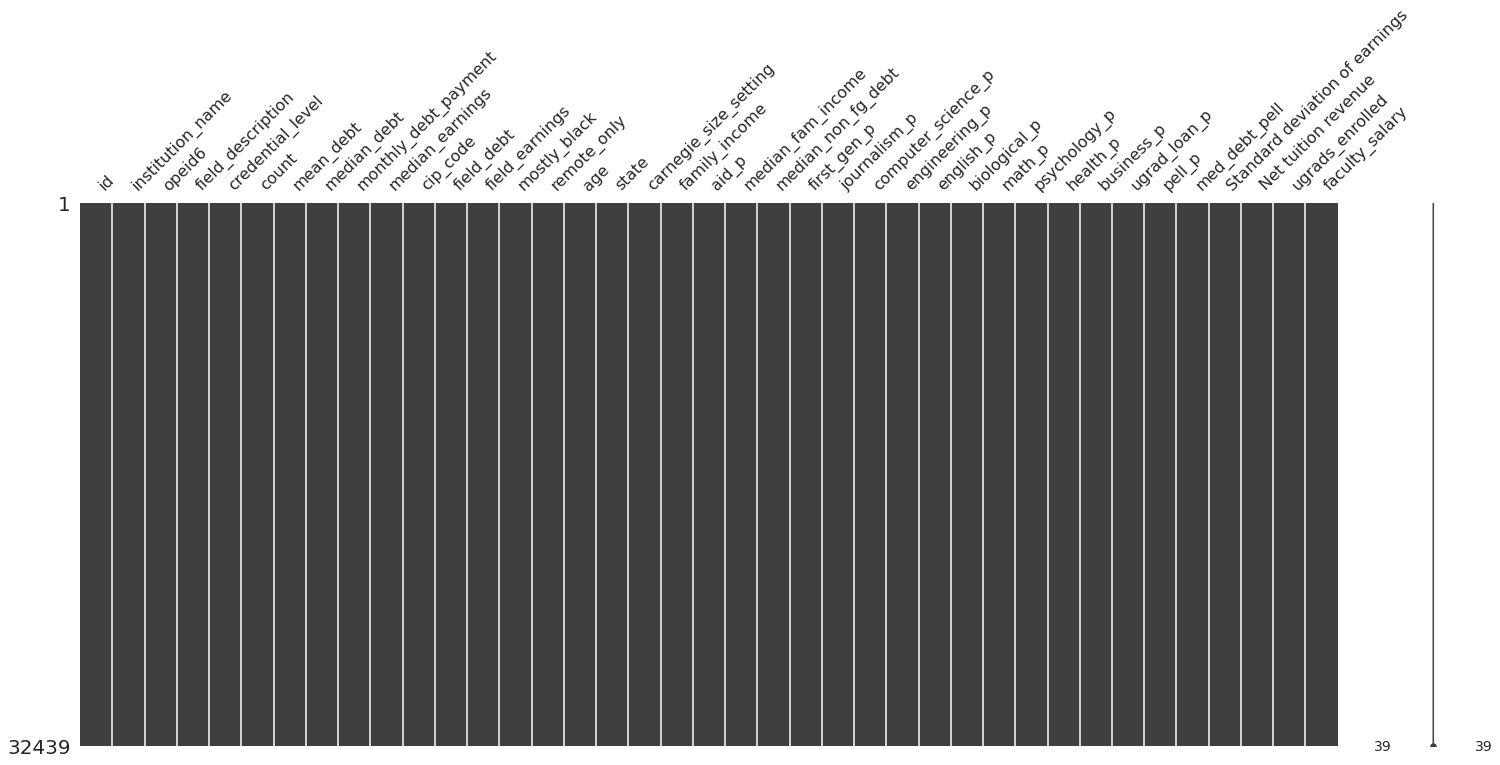

In [22]:
msno.matrix(MSF.toPandas())

Uncahce the previous msf dataframe, then cache the cleaned MSF dataFrame

In [23]:
msf.unpersist()
MSF.cache()

DataFrame[id: string, institution_name: string, opeid6: int, field_description: string, credential_level: int, count: int, mean_debt: int, median_debt: int, monthly_debt_payment: int, median_earnings: int, cip_code: string, field_debt: int, field_earnings: int, mostly_black: string, remote_only: string, age: int, state: string, carnegie_size_setting: int, family_income: int, aid_p: float, median_fam_income: bigint, median_non_fg_debt: int, first_gen_p: float, journalism_p: float, computer_science_p: float, engineering_p: float, english_p: float, biological_p: float, math_p: float, psychology_p: float, health_p: float, business_p: float, ugrad_loan_p: float, pell_p: float, med_debt_pell: float, Standard deviation of earnings: int, Net tuition revenue: int, ugrads_enrolled: int, faculty_salary: int]

# Some More Extensive Queries
## write queries that use aggregate functions

In [27]:
### What are most undergrads majoring in?
print("Undergraduate count per major:")
u_count = MSF \
    .where(col("credential_level") == 3)\
    .groupBy("field_description")\
    .agg(sum("count").alias("UndergradTotalCount"))\
    .orderBy(col("UndergradTotalCount").desc())
u_count.show(5, False)

print("Graduate count per major:")
g_count = MSF \
    .where(col("credential_level") > 4)\
    .groupBy("field_description")\
    .agg(sum("count").alias("GradTotalCount"))\
    .orderBy(col("GradTotalCount").desc())
g_count.show(5, False)

# Majors where there are more graduate degrees:

Undergraduate count per major:
+----------------------------------------------------------------------------------+-------------------+
|field_description                                                                 |UndergradTotalCount|
+----------------------------------------------------------------------------------+-------------------+
|Registered Nursing, Nursing Administration, Nursing Research and Clinical Nursing.|288216             |
|Business Administration, Management and Operations.                               |273944             |
|Psychology, General.                                                              |167612             |
|Criminal Justice and Corrections.                                                 |113454             |
|Biology, General.                                                                 |83165              |
+----------------------------------------------------------------------------------+-------------------+
only showing top 5 rows


In [32]:
print("Programs that generate the highest earnings/debt ratio:")
msf.select("institution_name", "field_description","earnings_debt_ratio")\
    .orderBy(col("earnings_debt_ratio").desc()).show(5)

print("Studying these majors will put you in debt for the longest time:")
#temp.select("institution_name", "cip_code" ,"field_description","years_to_pay_debt").orderBy(col("years_to_pay_debt").desc()).show(5)
msf.groupBy("field_description").agg(avg("years_to_pay_debt")\
    .alias("Average years to pay off debt"))\
    .orderBy(col("Average years to pay off debt").desc()).show(10, False)

Programs that generate the highest earnings/debt ratio:
+--------------------+--------------------+-------------------+
|    institution_name|   field_description|earnings_debt_ratio|
+--------------------+--------------------+-------------------+
| Fresno City College|Registered Nursin...| 20.885714285714286|
|Olivet Nazarene U...|Teaching English ...| 16.770670826833072|
|Ivy Tech Communit...|Electrical and Po...| 15.636588380716935|
|South Florida Ins...|Electrical/Electr...|  15.19453207150368|
|Walters State Com...|Registered Nursin...| 15.114754098360656|
+--------------------+--------------------+-------------------+
only showing top 5 rows

Studying these majors will put you in debt for the longest time:
+-----------------------------------------------------------+-----------------------------+
|field_description                                          |Average years to pay off debt|
+-----------------------------------------------------------+-----------------------------+
|C

# Data Visualization

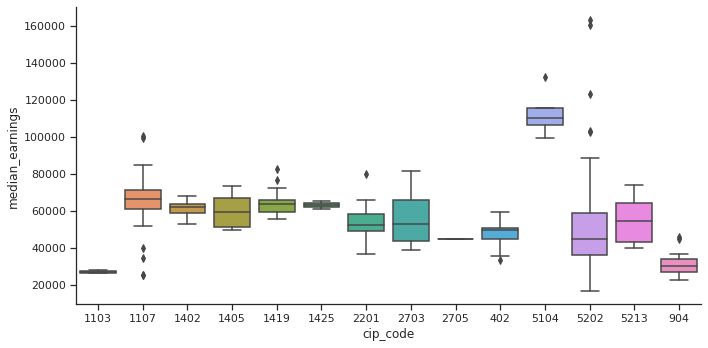

In [77]:
interested_fields = ['Architecture.', 'Journalism.', 'Computer Science.', 'Data Processing.', 'Aerospace, Aeronautical and Astronautical Engineering.', 'Biomedical/Medical Engineering.', 
'Mechanical Engineering.', 'Petroleum Engineering.', 'Electromechanical Engineering.', 'Law.', 'Applied Mathematics.', 'Statistics.', 'Dentistry.', 'Business Administration, Management and Operations', 'Management Sciences and Quantitative Methods.']
interested_cip = ['402','904', '1107', '1103', '1402', '1405', '1419', '1425', '1441', '2201', '2703', '2705', '5104', '5202', '5213']
sample_data = MSF.select("*").filter(MSF.cip_code.isin(interested_cip)).sample(True, 0.1, 843).toPandas()
sns.catplot(x="cip_code", y = "median_earnings", kind='box', data=sample_data, aspect=2)

In [29]:
print("In the above violin plot, from left to right:")
for i in range(len(interested_cip)):
    print("\t\t cip code {} corresponds to {}".format(interested_cip[i], interested_fields[i]))

In the above violin plot, from left to right:
		 cip code 402 corresponds to Architecture.
		 cip code 904 corresponds to Journalism.
		 cip code 1107 corresponds to Computer Science.
		 cip code 1103 corresponds to Data Processing.
		 cip code 1402 corresponds to Aerospace, Aeronautical and Astronautical Engineering.
		 cip code 1405 corresponds to Biomedical/Medical Engineering.
		 cip code 1419 corresponds to Mechanical Engineering.
		 cip code 1425 corresponds to Petroleum Engineering.
		 cip code 1441 corresponds to Electromechanical Engineering.
		 cip code 2201 corresponds to Law.
		 cip code 2703 corresponds to Applied Mathematics.
		 cip code 2705 corresponds to Statistics.
		 cip code 5104 corresponds to Dentistry.
		 cip code 5202 corresponds to Business Administration, Management and Operations
		 cip code 5213 corresponds to Management Sciences and Quantitative Methods.


Comparing income for undergraduate vs graduate degrees

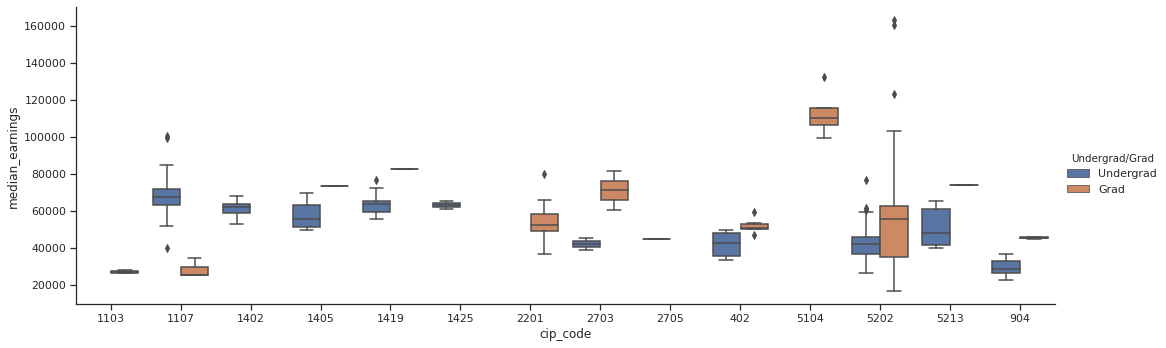

In [78]:
PDF = MSF.withColumn("Undergrad/Grad",when(MSF.credential_level == 3, 'Undergrad').otherwise('Grad'))
interested_fields = ['Architecture.', 'Journalism.', 'Computer Science.', 'Data Processing.', 'Aerospace, Aeronautical and Astronautical Engineering.', 'Biomedical/Medical Engineering.', 
'Mechanical Engineering.', 'Petroleum Engineering.', 'Electromechanical Engineering.', 'Law.', 'Applied Mathematics.', 'Statistics.', 'Dentistry.', 'Business Administration, Management and Operations', 'Management Sciences and Quantitative Methods.']
interested_cip = ['402','904', '1107', '1103', '1402', '1405', '1419', '1425', '1441', '2201', '2703', '2705', '5104', '5202', '5213']
sample_data2 = PDF.select("*").filter(PDF.cip_code.isin(interested_cip)).sample(True, 0.1, 843).toPandas()
sns.catplot(x="cip_code", y = "median_earnings", kind='box',hue="Undergrad/Grad", data=sample_data2,aspect=3)

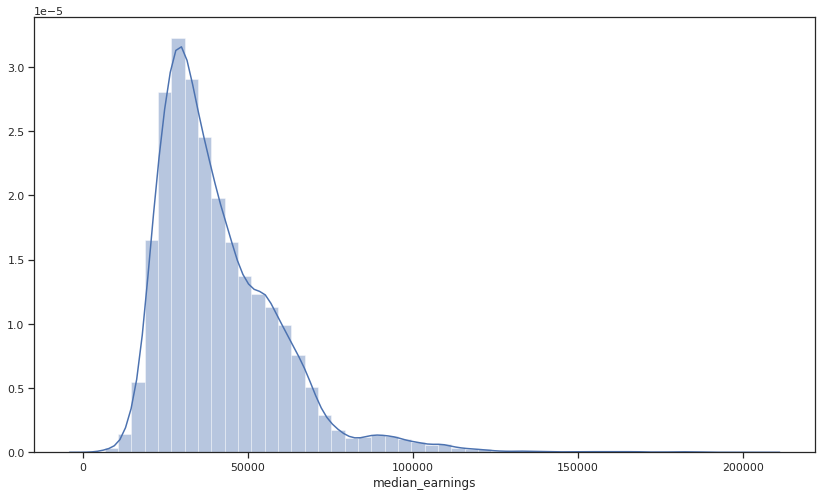

In [30]:
sns.distplot(MSF.toPandas()["median_earnings"] )

### Some Feature Engineering

Add features:
    1. earnings_debt_ratio
    2. years_to_pay_debt

In [31]:
# need to aggregate major, to explore ernings/debt
msf = msf.withColumn("earnings_debt_ratio", col("median_earnings") / col("median_debt"))\
          .withColumn("years_to_pay_debt", 1/col("earnings_debt_ratio"))\


Now, lets build up a regression model to predict earnings after graduation using mllib.

In [66]:
#Final Master Frame to be fed into the Rformula
FMSF = MSF.drop('id', 'institution_name', 'opeid6', 'field_description', 'largest_cip', 'second_largest_cip', 'largest_program', 'second_largest_program', 'state')

In [34]:
# Run these two cells to check for distinct value counts in each column
#c_names = FMSF.columns
#[(c, FMSF.select(c).distinct().count()) for c in c_names]

In [67]:
supervised = RFormula(formula="median_earnings ~ .")
fittedRF = supervised.fit(FMSF)
preparedDF = fittedRF.transform(FMSF)

In [ ]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(featureCols)

In [ ]:
len(featureCols)

In [68]:
lr = LinearRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(preparedDF)

In [70]:
print("Coefficients: %s" % str(lrModel.coefficients))

Coefficients: [5551.720176703182,-8.599876539415929,0.20140384235398248,-0.0720815113744523,6.67628854649198,4665.290643743014,25961.56463164102,-2736.1869301521033,-6025.342119908863,5012.633265808654,-11261.097629223192,-5933.914878817309,2147.7528427637326,6415.58035864379,17111.346387715636,-11935.433358887329,-8054.380699179041,-9564.958979495603,-11088.38375063187,3625.4477676472857,-13717.009053162956,13944.391582050423,-5375.666138784052,-102.91564477971014,1300.7633179843374,-8211.06369623041,-17711.465161204513,7940.570062173369,11940.85091895974,-11020.07639253176,-6099.913257590912,-12344.070172664082,1969.7895986003693,-4319.672961462793,18571.17786184241,-8155.656128244926,3050.7258969564377,12395.772345977575,-5009.371293117075,-13686.592542130049,-4219.094679607929,24280.94507853261,23769.902852608815,-12514.023117131714,14473.80344074355,-20814.631601563768,7650.442383440735,-4281.724543965585,-14407.9211171749,-4935.019143453699,-11760.496630460835,-21508.531717689468

## Automatic variable selection -- sklearn selectKbest
We are still left with 31 numerical columns and 8 categorical columns, we further narrow down our numerical features using automatic variable selection.

In [61]:
string_col = ['id', 'institution_name', 'opeid6', 'field_description', 'cip_code', 'mostly_black', 'remote_only', 'state']
temp = MSF.drop(*string_col)
pdf = temp.toPandas()
X = pdf[[c for c in temp.columns if c != "median_earnings"]]
Y = pdf [['median_earnings']].values
bestFeatures = SelectKBest(score_func=f_regression, k = 20)
fit = bestFeatures.fit(X.values,Y)

In [62]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

                           Feature         Score
0                 credential_level  11383.897026
2                        mean_debt   7463.612109
4             monthly_debt_payment   7109.349360
3                      median_debt   6605.659456
26  Standard deviation of earnings   4531.975765
29                  faculty_salary   3549.493368
24                          pell_p   2549.936476
8            carnegie_size_setting   1982.328876
9                    family_income   1849.435963
10                           aid_p   1812.228678
16                   engineering_p   1604.439365
13                     first_gen_p   1409.700784
11               median_fam_income   1339.665163
12              median_non_fg_debt   1136.470939
19                          math_p    995.642815
6                   field_earnings    963.607814
25                   med_debt_pell    960.646278
18                    biological_p    553.264066
5                       field_debt    537.507239
23                  

In [76]:
kDropped = []

True

Split our data into train, test sets. Build up parameter grid for hyper tuning for our regression model

In [ ]:
train, test = FMSF.randomSplit([0.9, 0.1], seed = 843)

In [ ]:
'''rForm = RFormula()
lr = LinearRegression()#.setLabelCol("label").setFeaturesCol("features")
stages = [rForm, lr]
pipeline = Pipeline().setStages(stages)

params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    "median_earnings ~ .",
    "median_earnings ~ . - earnings_count"])\
  .addGrid(lr.elasticNetParam, [0.25, 0.5, 0.75])\
  .build()

evaluator = RegressionEvaluator()

tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(RegressionEvaluator())'''

In [ ]:
#.addGrid(lr.regParam, [0, 1, 5, 10, 25])\
#.addGrid(lr.fitIntercept, [True, False])\

In [ ]:
#from pyspark.ml.feature import StringIndexer, OneHotEncoder
#temp = OneHotEncoder(inputCol = "cip_code", outputCol = "cip_index").transform(FMSF)

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["cip_index"],outputCol="features")
TEMP =  assembler.transform(temp)

In [ ]:
#featureIndexer =\
    #VectorIndexer(inputCol="cip_code", outputCol="indexedFeatures", maxCategories=4).fit(FMSF)